<a href="https://colab.research.google.com/github/ms624atyale/NLP_2023/blob/main/13_SentimentAnalysis_HarryPotter_AllSevenCopiesIncluded.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##🐹 🐾 🐟 This script is based on [**Prof. Hosung Nam's github (hsnam95)**](https://github.com/hsnam95) and [**Prof. Junkyu Lee's github (junkyuhufs)**](https://github.com/junkyuhufs)

In [ ]:
#@markdown ##🐹 🐾  <font color = 'red'> **[1] 복제하여 Harry Potter자료 가져오기**
!git clone https://github.com/ErikaJacobs/Harry-Potter-Text-Mining.git

In [ ]:
#@markdown ##🐹 🐾  <font color = 'blue'> **[2] 데이터 전처리: Pandas이용 데이터 정리 (책의 한 챕터가 한 셀에 있는 상태)**
import pandas as pd #Importing Pandas package
%cd /content/Harry-Potter-Text-Mining/Book Text

import glob
fns = glob.glob('*.txt')
df = pd.DataFrame()
for fn in fns:
  dftmp = pd.read_csv(fn, sep="@")
  df = pd.concat([df, dftmp])

%cd /content

df

In [ ]:
#@markdown ##🐹 🐾  **[3] 데이터 전처리 불용어(stopwords) 제거**
import nltk #Import NLTK library
nltk.download('stopwords')
nltk.download('punkt') #installed punkt to fix error
from nltk import word_tokenize
from nltk.corpus import stopwords #Import stopwords to Python

stopwords = set(stopwords.words('english')) #English stopwords assigned to "stopwords" object

import string #Punctuation

# Function for removing punctuation
def remove_punctuations(text):
    for punctuation in string.punctuation:
        text = text.replace(punctuation, '')
    return text

stopwords = [''.join(item for item in x if item not in string.punctuation) for x in stopwords] #Remove punctuation from stopwords

df['WordCountText']=df['Text'].str.lower().apply(remove_punctuations).apply(word_tokenize) # Word Count Text
# Word Count
df['WordCloudText']=df['WordCountText'].apply(lambda x: [word for word in x if word not in stopwords]) # Word Cloud Text
df['WordCount'] = df['WordCountText'].str.len() #Word Count Per Chapter

In [ ]:
#@markdown ##🐹 🐾  **[4] 데이터 전처리: 책 > 문장단위로 (챕터가 문장단위로 나뉜 상태)**
# Creating a table breaking down the text by each sentence, rather than each chapter.
from nltk import sent_tokenize
from nltk import word_tokenize
from nltk.stem import PorterStemmer

# Make smaller table - reset index to prepare for further work
dfsentiment = df[['Book','Chapter','Text']].reset_index() \
    .drop(["index"], axis=1)
dfsentiment = dfsentiment.join(dfsentiment.Text.apply(sent_tokenize).rename('Sentences')) # Breaking apart text into sentences

#Put every tokenized sentence into its own row
dfsentiment2 = dfsentiment.Sentences.apply(pd.Series) \
    .merge(dfsentiment, left_index = True, right_index = True) \
    .drop(["Text"], axis = 1) \
    .drop(["Sentences"], axis = 1) \
    .melt(id_vars = ['Book', 'Chapter'], value_name = "Sentence") \
    .drop("variable", axis = 1) \
    .dropna()

# Sort new table by Book and Chapter - reset index to reflect new order
dfsentiment2=dfsentiment2.sort_values(by=['Book', 'Chapter']) \
    .reset_index() \
    .drop(['index'], axis = 1)

# Clean punctuation, lower case
dfsentiment2['Sentence']=dfsentiment2.Sentence.apply(remove_punctuations).apply(lambda x: x.lower()) \

# Check first five values
dfsentiment2

In [ ]:
#@markdown ##🐹 🐾 **[5] 필요한 라이브러리(VADER library) 불러오기**
#>
#@markdown <font color = 'blue black'> "vader" refers to the VADER (Valence Aware Dictionary and sEntiment Reasoner) sentiment analysis tool, which is implemented as part of NLTK's sentiment module.

#@markdown VADER is **_valence aware_** because it takes into account the intensity of sentiment expressed in the text. It uses a pre-built lexicon (dictionary) of words, each annotated with a sentiment score indicating the positivity or negativity of the word. Additionally, it considers various grammatical and syntactical rules to interpret the sentiment expressed by the combination of words in a sentence.

from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
nltk.download('vader_lexicon')
sid=nltk.sentiment.vader.SentimentIntensityAnalyzer()

###Harry Potter 예시문장 (stemmed 문장)


|출처 | 예시문장 | 감정 |
|--|--|--|
|[0,1,1]|'the boy who lived mr and mrs dursley of number four privet drive were **proud** to say that they were perfectly normal **thank** you very much'|😄 Positive|[0,1,1]|
|[1,1,1]|'they were the last people youd expect to be involved in anything **strange** or **mysterious** because they just didnt hold with such **nonsense**'|😡 Negative |
|[2,1,1]|'mr dursley was the director of a firm called grunnings which made drills'|😐 Neutral|


+ *Note*. 출처 == [sentence number, Book, Chapter]

In [6]:
#@markdown ##🐹 🐾 **[6] 문장별로 감정분석 점수 부여; Compound, positive, negative, neutral**
# Get intensity scores of each sentence
dfsentiment2['Score']=dfsentiment2.Sentence.apply(lambda x: sid.polarity_scores(x))

# Place scores in own columns
dfsentiment2['CompScore']=dfsentiment2.Score.apply(lambda x: x.get("compound"))
dfsentiment2['PosScore']=dfsentiment2.Score.apply(lambda x: x.get("pos"))
dfsentiment2['NegScore']=dfsentiment2.Score.apply(lambda x: x.get("neg"))
dfsentiment2['NeuScore']=dfsentiment2.Score.apply(lambda x: x.get("neu"))

# With scores extracted, the original score field can be removed
dfsentiment2 = dfsentiment2.drop(["Score"], axis=1)

# Adding Sentiment Flags
dfsentiment2['PosFlag'] = dfsentiment2.CompScore.apply(lambda x: 1 if x >= 0.05 else 0)
dfsentiment2['NegFlag'] = dfsentiment2.CompScore.apply(lambda x: 1 if x <= -0.05 else 0)
dfsentiment2['NeuFlag'] = dfsentiment2.CompScore.apply(lambda x: 1 if x < 0.05 and x > -0.05 else 0)

In [ ]:
#@markdown ##🐹 🐾 **[7] 처음 나온 결과 20개 보기**
dfsentiment2.head(20)

* Negative Flag:  18385
* Neutral Flag:  33544
* Positive Flag:  19055
Total:  70984


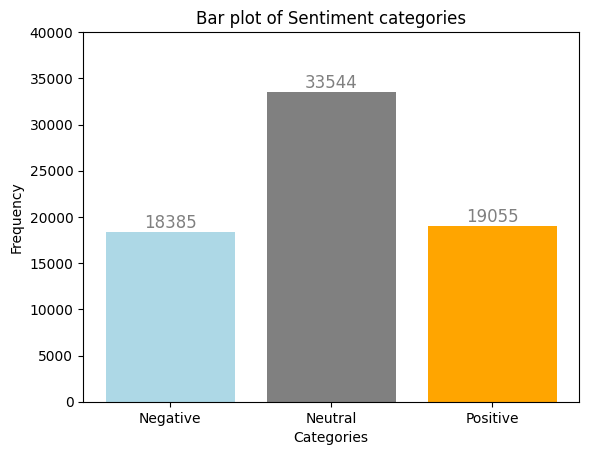

In [8]:
#@markdown ##🐹 🐾 **[8] <font color = 'red'> 감정분석 결과 막대그래프 (부정, 중립, 긍정)**

print('* Negative Flag: ', dfsentiment2['NegFlag'].sum())
print('* Neutral Flag: ', dfsentiment2['NeuFlag'].sum())
print('* Positive Flag: ', dfsentiment2['PosFlag'].sum())
print("="*50)
print('Total: ',dfsentiment2['PosFlag'].sum()+dfsentiment2['NeuFlag'].sum()+dfsentiment2['NegFlag'].sum())


import numpy as np
import matplotlib.pyplot as plt

Negative = int(dfsentiment2['NegFlag'].sum())
Neutral = int(dfsentiment2['NeuFlag'].sum())
Positive = int(dfsentiment2['PosFlag'].sum())

# Your three integer frequencies
freqs = [Negative, Neutral, Positive]
# freqs = [18385, 33544, 19055]

# Create labels for the bars
labels = ['Negative', 'Neutral', 'Positive']

# Create x coordinates for the bars
x = np.arange(len(labels))

# Generate the bar plot
plt.bar(x, freqs)


# Specify the colors for each category
colors = ['lightblue', 'gray', 'orange']

# Generate the bar plot with custom colors

bars = plt.bar(x, freqs, color=colors)
# Add labels to the x-axis
plt.xticks(x, labels)

# Set axis labels
plt.xlabel('Categories')
plt.ylabel('Frequency')

# Set a title for the plot
plt.title('Bar plot of Sentiment categories')
plt.ylim(0, 40000)
# Add the frequency text within each bar
for bar, freq in zip(bars, freqs):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() - 2, str(freq),
             ha='center', va='bottom', fontsize=12, color='gray')


# Display the plot
plt.show()

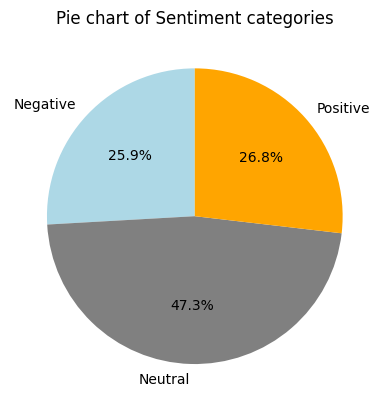

In [9]:
#@markdown ##🐹 🐾 **[9] <font color = 'red'> 감정분석 카테고리 파이차트 (비율확인용)**
import numpy as np
import matplotlib.pyplot as plt

Negative = int(dfsentiment2['NegFlag'].sum())
Neutral = int(dfsentiment2['NeuFlag'].sum())
Positive = int(dfsentiment2['PosFlag'].sum())

# Your three integer frequencies
freqs = [Negative, Neutral, Positive]

# Create labels for the segments
labels = ['Negative', 'Neutral', 'Positive']

# Specify the colors for each segment
colors = ['lightblue', 'gray', 'orange']

# Generate the pie chart with custom colors
plt.pie(freqs, labels=labels, colors=colors, autopct='%.1f%%', startangle=90)

# Set a title for the plot
plt.title('Pie chart of Sentiment categories')

# Display the plot
plt.show()

<ipython-input-10-4471c9184b78>:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  dfsentiment2.groupby('Book').mean()['CompScore']
<ipython-input-10-4471c9184b78>:34: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  dfsentiment2.groupby(['Chapter','BookTitle']).mean()['CompScore'].unstack().plot(ax=ax, subplots=True, ylim=(-0.25, 0.25), colormap=ColorMap)
<ipython-input-10-4471c9184b78>:34: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  dfsentiment2.groupby(['Chapter','BookTitle']).mean()['CompScore'].unstack().plot(ax=ax, subplots=True, ylim=(-0.25, 0.25), c

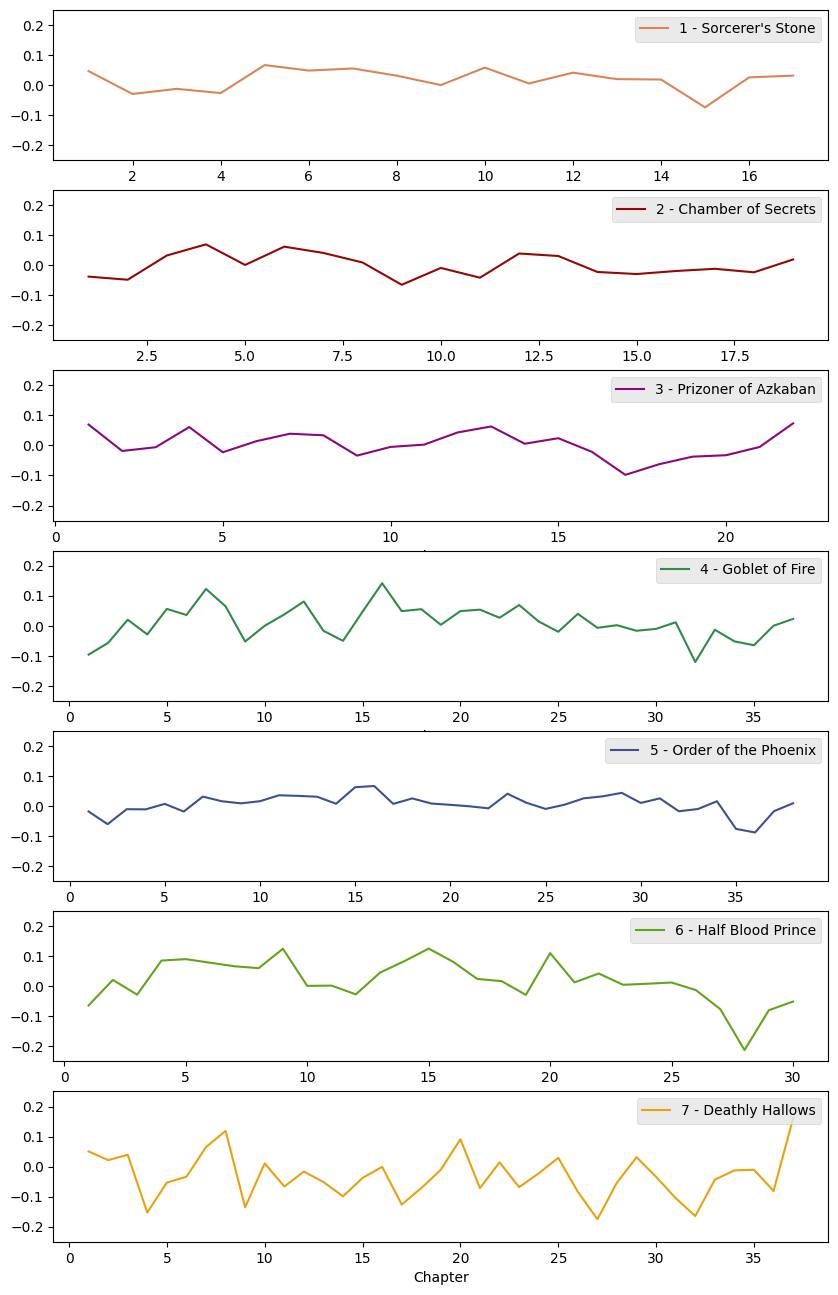

In [10]:
#@markdown ##🐹 🐾 **[10] <font color = 'red'> 7권 개별적으로 감정변화 흐름 확인**
#Time series of sentiments in 7 books of Harry Potter

dfsentiment2.groupby('Book').mean()['CompScore']

def Titles(x):
    if x == 1:
        return "1 - Sorcerer's Stone"
    if x == 2:
        return "2 - Chamber of Secrets"
    if x == 3:
        return "3 - Prizoner of Azkaban"
    if x == 4:
        return "4 - Goblet of Fire"
    if x == 5:
        return "5 - Order of the Phoenix"
    if x == 6:
        return "6 - Half Blood Prince"
    if x == 7:
        return "7 - Deathly Hallows"

dfsentiment2['BookTitle']=dfsentiment2.Book.apply(lambda x: Titles(x))

import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

colorsList = ['#DC8458', '#950702', '#8E067D', '#2E8C44', '#395196', '#60A619','#ECA10A'] #Mauraders Map Colors
ColorMap = matplotlib.colors.ListedColormap(colorsList)

# plot data
fig, ax = plt.subplots(figsize=(10,16))
# use unstack()
dfsentiment2.groupby(['Chapter','BookTitle']).mean()['CompScore'].unstack().plot(ax=ax, subplots=True, ylim=(-0.25, 0.25), colormap=ColorMap)
plt.style.use('ggplot')
ax.set_ylabel('Compound Sentiment Score')

[ax.legend(loc=1) for ax in plt.gcf().axes]

<ipython-input-11-dd65d6f4e1ce>:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  dfsentiment2.groupby('Book').mean()['CompScore']
<ipython-input-11-dd65d6f4e1ce>:34: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  dfsentiment2.groupby(['Chapter','BookTitle']).mean()['CompScore'].unstack().plot(ax=ax, subplots=False, ylim=(-0.3, 0.3), colormap=ColorMap)


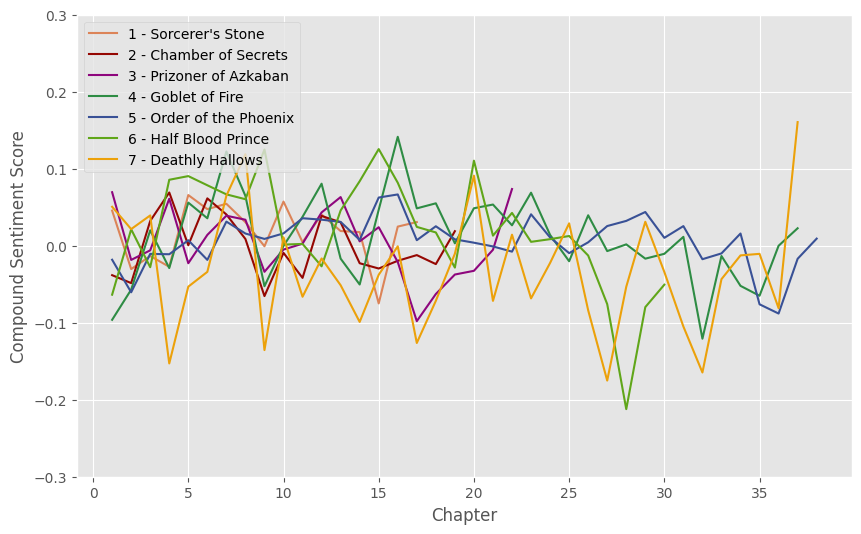

In [11]:
#@markdown ##🐹 🐾 **[11] <font color = 'red'>7권을 통합하여 감정변화 흐름 확인**
#Time series of sentiments in 7 books of Harry Potter

dfsentiment2.groupby('Book').mean()['CompScore']

def Titles(x):
    if x == 1:
        return "1 - Sorcerer's Stone"
    if x == 2:
        return "2 - Chamber of Secrets"
    if x == 3:
        return "3 - Prizoner of Azkaban"
    if x == 4:
        return "4 - Goblet of Fire"
    if x == 5:
        return "5 - Order of the Phoenix"
    if x == 6:
        return "6 - Half Blood Prince"
    if x == 7:
        return "7 - Deathly Hallows"

dfsentiment2['BookTitle']=dfsentiment2.Book.apply(lambda x: Titles(x))

import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

colorsList = ['#DC8458', '#950702', '#8E067D', '#2E8C44', '#395196', '#60A619','#ECA10A'] #Mauraders Map Colors
ColorMap = matplotlib.colors.ListedColormap(colorsList)

# plot data
fig, ax = plt.subplots(figsize=(10,6))
# use unstack()
dfsentiment2.groupby(['Chapter','BookTitle']).mean()['CompScore'].unstack().plot(ax=ax, subplots=False, ylim=(-0.3, 0.3), colormap=ColorMap)
plt.style.use('ggplot')
ax.set_ylabel('Compound Sentiment Score')

[ax.legend(loc=2) for ax in plt.gcf().axes]